In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import pandas as pd
from time import sleep
from collections import defaultdict

warnings.filterwarnings(action='ignore')

from tqdm import tqdm
from crawler.utils.elasticsearch import ElasticSearchUtils

%matplotlib inline

In [3]:
es = {
    'corpus': ElasticSearchUtils(**{
        'host': 'https://corpus.ncsoft.com:9200',
        'http_auth': 'ZWxhc3RpYzpubHBsYWI=',
        'encoded_auth': True
    }),
    'backfill': ElasticSearchUtils(**{
        'host': 'https://crawler-es.cloud.ncsoft.com:9200',
        'http_auth': 'ZWxhc3RpYzpzZWFyY2hUMjAyMA==',
        'encoded_auth': True
    })
}


In [4]:
index_size = {
    'corpus': {x['index']: x['count'] for x in es['corpus'].get_index_size()},
    'backfill': {x['index']: x['count'] for x in es['backfill'].get_index_size()},
}

index_size

{'corpus': {'crawler-bbs-game-bns-eng': 18022,
  'crawler-bbs-game-lineage-vi': 120663,
  'crawler-bbs-game-lineage2-eng': 11016,
  'crawler-bbs-game-lineagem-jap': 23075,
  'crawler-bbs-inven': 7951,
  'crawler-bbs-inven-2017': 77128,
  'crawler-bbs-inven-2018': 150782,
  'crawler-bbs-inven-2019': 282522,
  'crawler-bbs-inven-2020': 151212,
  'crawler-bbs-inven-2021': 3523,
  'crawler-bbs-inven-error': 2389,
  'crawler-bbs-lineage2m': 98713,
  'crawler-bbs-lineage2m-error': 272,
  'crawler-bbs-lineagem': 840628,
  'crawler-bbs-lineagem-2017': 406088,
  'crawler-bbs-lineagem-2018': 166912,
  'crawler-bbs-lineagem-2019': 76475,
  'crawler-bbs-lineagem-error': 1526,
  'crawler-bbs-mlbpark_bullpen': 46698,
  'crawler-bbs-mlbpark_bullpen-2017': 49201,
  'crawler-bbs-mlbpark_bullpen-2018': 1017694,
  'crawler-bbs-mlbpark_bullpen-2019': 2231986,
  'crawler-bbs-mlbpark_bullpen-2020': 1698005,
  'crawler-bbs-mlbpark_bullpen-2021': 175158,
  'crawler-bbs-mlbpark_bullpen-error': 540,
  'crawler-

In [5]:
df = pd.DataFrame(index_size).fillna(0)
df

,corpus,backfill
crawler-bbs-game-bns-eng,18022,0.0
crawler-bbs-game-lineage-vi,120663,0.0
crawler-bbs-game-lineage2-eng,11016,0.0
crawler-bbs-game-lineagem-jap,23075,0.0
crawler-bbs-inven,7951,0.0
...,...,...
sample-dcinside-2021,322104,0.0
temp_yhnews_tv_sports_2020,867643,0.0
test-economy-2021-02,62022,0.0
test-mapping,2,0.0


In [11]:
df = df[ df['backfill'] != 0 ]

In [16]:
df['diff'] = df['corpus'] - df['backfill']

In [17]:
pd.set_option('precision', 0)
pd.set_option('display.max_rows', None)

df.style.set_properties(**{'text-align': 'right'}).format('{:,.0f}')

,corpus,backfill,diff
crawler-bbs-mlbpark_bullpen-2019,"2,231,986","61,715","2,170,271"
crawler-bbs-mlbpark_bullpen-2020,"1,698,005","1,791,520","-93,515"
crawler-bbs-mlbpark_bullpen-2021,"175,158","459,160","-284,002"
crawler-bbs-mlbpark_kbo-2019,"761,514","262,426","499,088"
crawler-bbs-mlbpark_kbo-2020,"470,863","961,597","-490,734"
crawler-bbs-mlbpark_kbo-2021,"58,439","48,774","9,665"
crawler-bbs-mlbpark_mlb-2017,"89,346","84,586","4,760"
crawler-bbs-mlbpark_mlb-2018,"93,922","85,697","8,225"
crawler-bbs-mlbpark_mlb-2019,"118,423","108,124","10,299"
crawler-bbs-mlbpark_mlb-2020,"59,980","52,819","7,161"


In [25]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 15})
        
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
rc('font', family=font_manager.FontProperties(fname=font_path).get_name())

<AxesSubplot:>

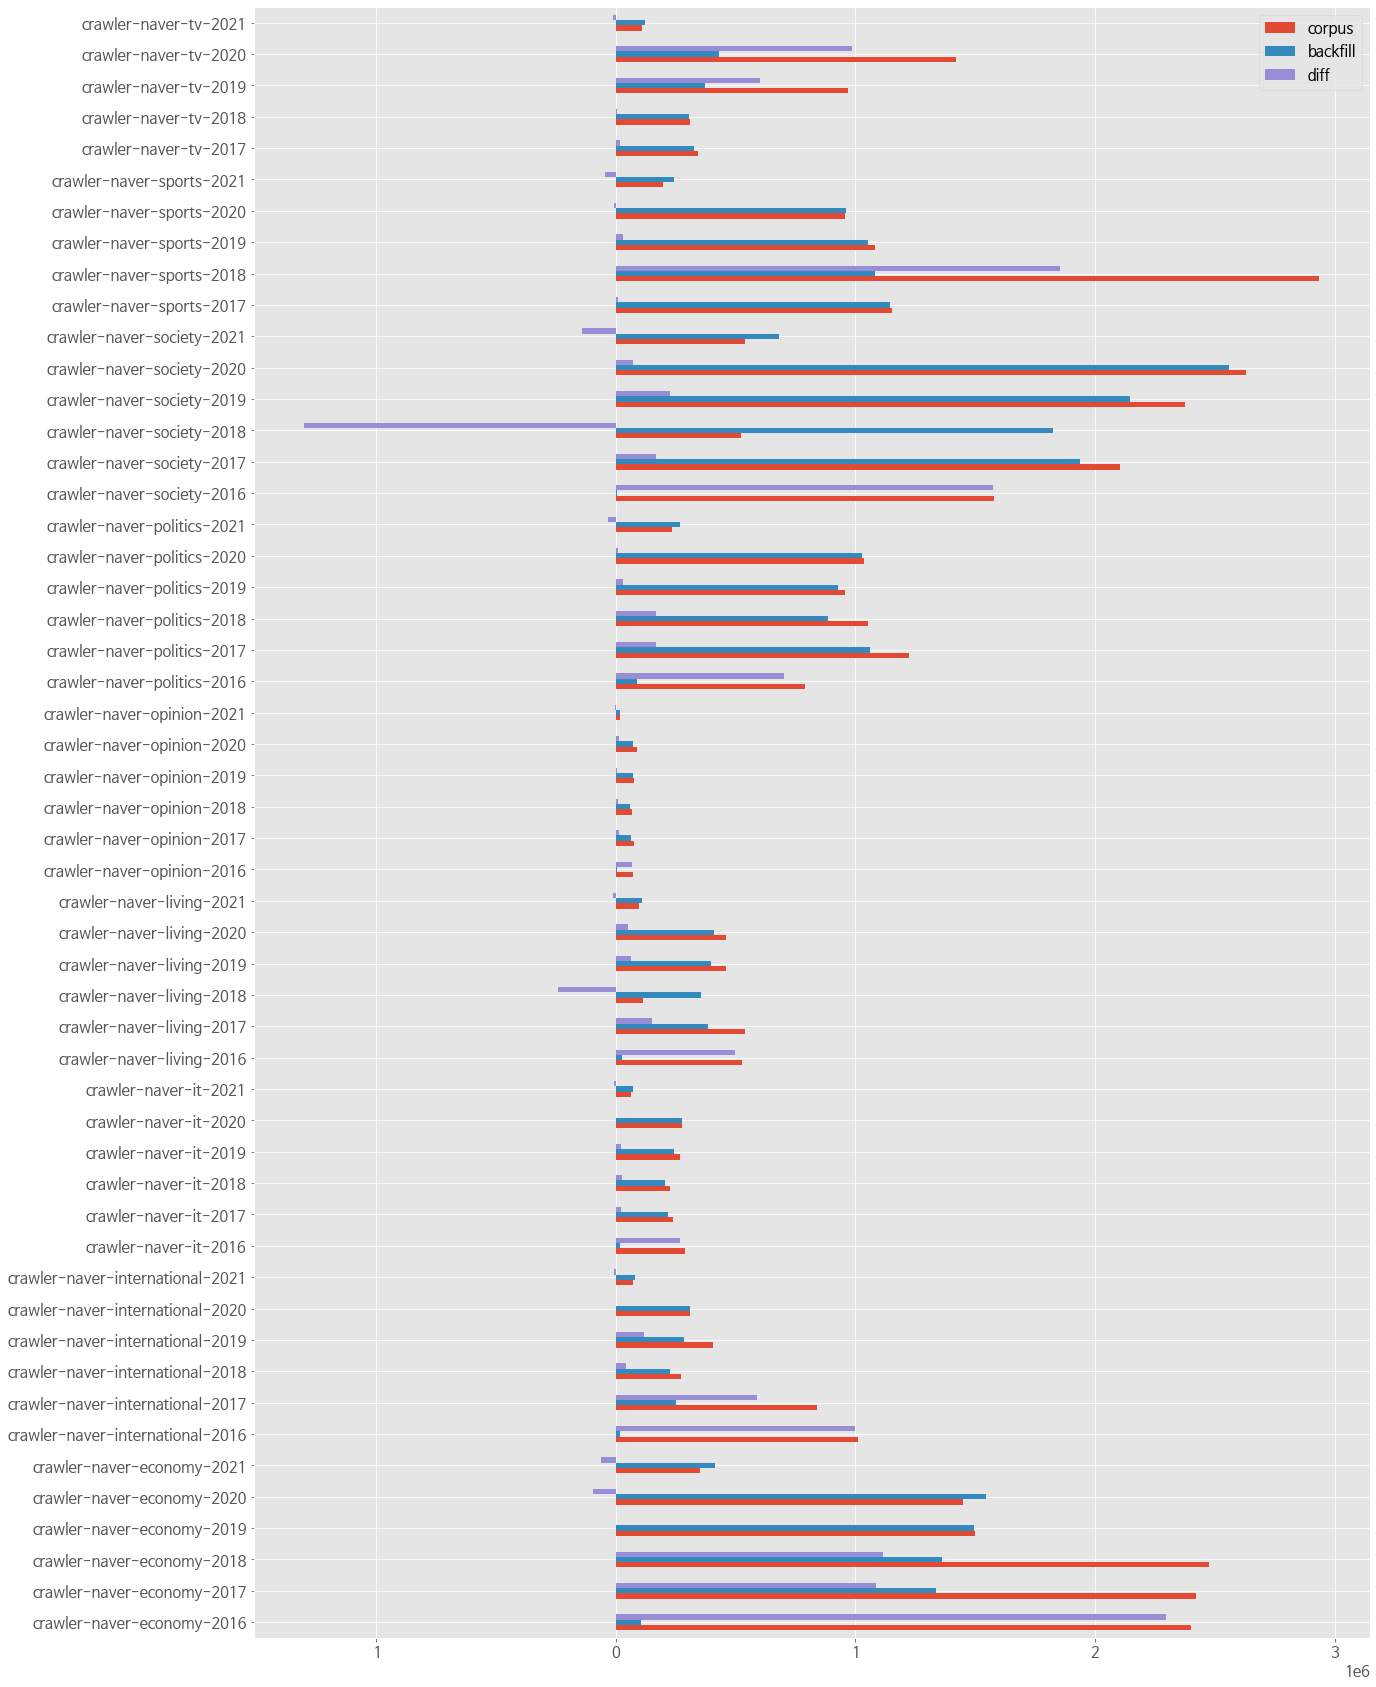

In [27]:
df[ df.index.str.find('crawler-naver-') == 0 ].plot(kind='barh', figsize=(20, 30))

In [ ]:
index = 'crawler-naver-economy-2021'
date_range = '2021-01-01~2021-03-20'

In [ ]:
dt_query = es['backfill'].get_date_range_query(date_range=date_range)
query = {
    'corpus': {
        'track_total_hits': True,
        '_source': [''],
        'query': {
            'bool': {
                'must': [{
                    'exists': {
                        'field': 'raw'
                    }
                }, {
                    **dt_query['query']['bool']['must']
                }]
            }
        }
    },
    'backfill': {
        'track_total_hits': True,
        '_source': [''],
        'query': {
            'bool': {
                'must': [
                    dt_query['query']['bool']['must']
                ],
                'must_not': [{
                    'exists': {
                        'field': 'contents'
                    }
                }]
            }
        }
    }
}

doc_list = {
    'corpus': [],
    'backfill': [],
}

es['corpus'].dump_index(index=index, query=query['corpus'], result=doc_list['corpus'])
es['backfill'].dump_index(index=index, query=query['backfill'], result=doc_list['backfill'])

In [ ]:
ids = {
    'corpus': set((x['_index'], x['_id']) for x in doc_list['corpus']),
    'backfill': set((x['_index'], x['_id']) for x in doc_list['backfill']),
}

ids['common'] = list(ids['backfill'].intersection(ids['corpus']))

missing = {
    'corpus': list(ids['backfill'].difference(ids['corpus'])),
    'backfill': list(ids['corpus'].difference(ids['backfill'])),
}

summary = {
    'count': {col: f'{len(x):,}' for col, x in doc_list.items()},
    'missing': {col: f'{len(x):,}' for col, x in missing.items()}
}

print(len(ids['common']))

pd.DataFrame(summary)

In [ ]:
from collections import defaultdict

idx = defaultdict(list)
for k, v in ids['common'][:10]:
    idx[k].append(v)
    
idx

# 공통 아이디 복사: corpus -> backfill

* raw, content -> raw, contents

In [ ]:
size = 100
for i in tqdm(range(0, len(ids['common']), size)):
    id_list = ids['common'][i:i + size]

    docs = []
    es['corpus'].get_by_ids(index=index,
                            id_list=[x[1] for x in id_list],
                            result=docs,
                            source=['raw', 'content'])

    bulk = []
    for x in docs:
        if 'raw' not in x or 'content' not in x:
            continue
            
        bulk += [{
            'update': {
                '_id': x['_id'],
                '_index': index,
            }
        }, {
            'doc': {
                'raw': x['raw'],
                'contents': x['content'],
            },
            'doc_as_upsert': False,
        }]

    resp = es['backfill'].conn.bulk(index=index, body=bulk, refresh=True)


# 차이 나는 문서 확인 

In [ ]:
doc_id = missing['backfill'][0]

[
    doc_id, 
    doc_id in ids['backfill'],
    es['corpus'].conn.get(index=index, id=doc_id, _source=['title'])['_source'],
    es['backfill'].conn.get(index=index, id=doc_id, _source=['title'])['_source']
]

In [ ]:
es['corpus'].conn.get(index=index, id='20210120T113356505436', _source=['title', 'url'])['_source']

In [ ]:
query = {
    '_source': ['title', 'url'],
    "query": {
        "bool": {
            "must": [{
                "match_phrase": {
                    "title": "여자핸드볼 SK, 광명시와 연고지 협약…임오경 의원 지역구(종합)"
                }
            }]
        }
    }
}

[
    es['corpus'].conn.search(index=index, body=query)['hits']['hits'][0]['_source'],
    es['backfill'].conn.search(index=index, body=query)['hits']['hits'][0]['_source'],
]